# Метод ближайших соседей

### Алгоритм
Реализуйте метод ближайших соседей:
* Алгоритм должен работать с окнами фиксированного и нефиксированного размера.
* Алгоритм должен работать с различными ядрами. Не менее 4 штук. Обязательно должно быть Равномерное и Гауссово ядро. Желательно, чтобы было Гауссово и общее ядро вида (1 - |u|ᵃ)ᵇ.
* Алгоритм должен работать с различными метриками. Не менее 3 штук. Обязательно должно быть Косинусное расстояние. Желательно, чтобы было Косинусное расстояние и расстояние Минковского Lp.
* Алгоритм должен работать с априорными весами.
* Разрешается использовать готовую реализацию алгоритма поиска ближайших объектов.
* Выберете аналогичную библиотечную реализацию  метода ближайших соседей.
### Набор данных
* Выберите любой набор данных для задачи классификации. Желательно использовать набор данных с курса Анализа данных.
* Преобразуйте его в числовой вид и нормализуйте.
* Разбейте его на тренировочную и тестовую часть.
* Выберите целевую функцию ошибки или качества.
### Гиперпараметры
Найдите лучшие гиперпараметры:
* Гиперпараметры требуется настроить для реализованного и библиотечного алгоритма.
* Для поиска желательно использовать библиотеку optuna.
* Тестовое множество не должно использоваться для валидации при поиске.
* Выведите лучшие значения гиперпараметров для обоих алгоритмов.
* Для обоих алгоритмов постройте график зависимости целевой функции ошибки/качества на тестовом и тренировочном множестве в зависимости от числа соседей или ширины окна (смотря какая функция оказалась лучше). Остальные гиперпараметры должны быть зафиксированы.
### Поиск аномалий
* Реализуйте алгоритм поиска аномалий LOWESS.
* Взвесьте объекты из тренировочного множества.
* Вычислите результат валидации реализованного алгоритма на тестовом множестве до и после взвешивания.
* Повторите предыдущий пункт с библиотечным алгоритмом. Если он не поддерживает априорные веса, используйте семплирование.

### Импортируем все нужные библиотеки для решения задачи

In [106]:
import optuna
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import operator
from optuna.samplers import TPESampler
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

### Набор данных

Валидируем наши данные, избавляемся от не числовых данных. Удаляем дубликаты и добавляем наш оприорный вес в виде среднего значения каждой строки.

In [107]:
df = pd.read_csv("train.csv")
df = df.drop_duplicates()
df.drop(['Name', 'Ticket', 'Cabin', 'PassengerId'], axis=1,inplace=True)
df = df.copy()
df = df.dropna(axis=0)
df['Sex'] = df['Sex'].replace({'male':0, 'female':1})
df

/var/folders/vl/prr0fm7n2hx824svv5s907s1ffv301/T/ipykernel_32830/2857773582.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Sex'] = df['Sex'].replace({'male':0, 'female':1})


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.0,1,0,7.2500,S
1,1,1,1,38.0,1,0,71.2833,C
2,1,3,1,26.0,0,0,7.9250,S
3,1,1,1,35.0,1,0,53.1000,S
4,0,3,0,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
885,0,3,1,39.0,0,5,29.1250,Q
886,0,2,0,27.0,0,0,13.0000,S
887,1,1,1,19.0,0,0,30.0000,S
889,1,1,0,26.0,0,0,30.0000,C


Нормализуем наши данные. Разбиваем наши данные на тренировочную и тестовую часть

In [108]:
X = df[['Pclass', 'Sex', 'Fare', 'Embarked', 'Age']]
X = pd.get_dummies(X, dtype=float)
y = df['Survived']
X = X.to_numpy()
y = y.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)

sc = StandardScaler()
x_train_std = sc.fit_transform(X_train)
x_test_std = sc.transform(X_test)
x_train_std

array([[ 0.91632276, -0.80222463, -0.51788718, ..., -0.48552241,
        -0.19364917,  0.5417624 ],
       [ 0.91632276,  1.24653366, -0.51835688, ..., -0.48552241,
        -0.19364917,  0.5417624 ],
       [-0.27825508,  1.24653366, -0.41972053, ..., -0.48552241,
        -0.19364917,  0.5417624 ],
       ...,
       [ 0.91632276,  1.24653366, -0.45479186, ..., -0.48552241,
        -0.19364917,  0.5417624 ],
       [-1.47283291, -0.80222463, -0.10596301, ...,  2.05963717,
        -0.19364917, -1.84582763],
       [-0.27825508, -0.80222463, -0.26941753, ..., -0.48552241,
        -0.19364917,  0.5417624 ]])

### Алгоритм

In [109]:
class KNN:
    def __init__(self, k=5, metric='cosine', kernel='gaussian', apriory_weights=None, window=None, window_type='Non_fixed', p=0.5):
        self.k = k
        self.metric = metric
        self.kernel = kernel
        self.apriory_weights = apriory_weights
        self.window = window
        self.p = p
        self.eps = 0.0001
        self.window = window
        self.window_type = window_type

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        return self

    def dist_metric(self, x1, x2):
        if len(x1) != len(x2):
            raise ValueError('x1 and x2 must have same length')
        if self.metric == 'minkowski':
            sm = sum(abs(x1[i] - x2[i]) ** self.p for i in range(len(x1)))
            return sm ** (1 / self.p)
        elif self.metric == 'cosine':
            sum1 = sum(x1[i] * x2[i] for i in range(len(x1)))
            sum2 = sum(x1[i] ** 2 for i in range(len(x1)))
            sum3 = sum(x2[i] ** 2 for i in range(len(x2)))
            return 1 - sum1 / ((sum2 ** 0.5 * sum3 ** 0.5) + self.eps)
        elif 'chebishev':
            return max(0, max(abs(a - b) for a, b in zip(x1, x2)))

    def get_kernel(self, u):
        if self.kernel == 'uniform':
            if u <= -1 or u >= 1:
                return 0
            return 0.5
        elif self.kernel == 'triangular':
            if u <= -1 or u >= 1:
                return 0
            return max(0, 1 - abs(u))
        elif self.kernel == 'epanechnikov':
            if u <= -1 or u >= 1:
                return 0
            return 0.75 * (1 - u ** 2)
        elif self.kernel == 'gaussian':
            return (1 / (np.sqrt(2 * np.pi))) * np.exp(-(u ** 2) / 2)
        else:
            raise ValueError("Invalid kernel type")

    def predict(self, X_test):
        predictions = []
        for i in range(len(X_test)):
            distances = []
            for j in range(len(self.X_train)):
                distance = self.dist_metric(X_test[i], self.X_train[j])
                distances.append((distance, self.y_train[j]))
            distances.sort(key=operator.itemgetter(0))
            neighbors = distances[:self.k]
            if self.window_type == 'Non_fixed':
                self.window = distances[self.k][0]
            k_neighbors = [x[1] for x in neighbors]
            if self.apriory_weights is None:
                weights = [self.get_kernel(x[0]) / (self.window + self.eps) for x in neighbors]
            else:
                weights = [self.get_kernel(neighbors[j][0]) / self.window * self.apriory_weights[j] for j in range(len(neighbors))]
            class_votes = {}
            for j in range(len(k_neighbors)):
                class_votes[k_neighbors[j]] = class_votes.get(k_neighbors[j], 0) + weights[j]
            predictions.append(max(class_votes, key=class_votes.get))
        return predictions

### Гиперпараметры

С помощью библиотеки optuna находим самые лучшие гиперпараметры для реализованого алгоритма

In [110]:
def objective(trial):
    scalers = trial.suggest_categorical("scalers", ['minmax', 'standard', 'robust'])

    if scalers == "minmax":
        scaler = MinMaxScaler()
    elif scalers == "standard":
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()

    n_neighbors = trial.suggest_int("n_neighbors", 1, 30)
    window_type = trial.suggest_categorical('window_type', ['Fixed', 'Non_fixed'])
    if window_type == 'Fixed':
        window = trial.suggest_float("window", 1.0, 10.0)
    else:
        window = None
    weights = trial.suggest_categorical("weights", ['uniform', 'gaussian', 'triangular', 'epanechnikov'])
    metrics = trial.suggest_categorical("metric", ['minkowski', 'cosine', 'chebishev'])
    if metrics == 'minkowski':
        p = trial.suggest_float("p", 0.1, 10.0)
    else:
        p = None
    knn = KNN(k=n_neighbors, metric=metrics,  kernel=weights, window=window, window_type=window_type, p=p)

    pipeline = make_pipeline(scaler, knn)
    kfold = StratifiedKFold(n_splits=10)
    score = cross_val_score(pipeline, x_train_std, y_train, scoring='accuracy', cv=kfold)
    score = score.mean()
    return score

sampler = TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=300)

best_params = study.best_params
best_score = study.best_value
print("Лучшие гиперпараметры:", best_params)
print("Лучшее значение метрики качества:", best_score)

[I 2024-03-28 23:57:09,626] A new study created in memory with name: no-name-9748a136-84a7-4bc4-b5e8-7d6e493f91b0
[I 2024-03-28 23:57:10,190] Trial 0 finished with value: 0.7868979591836734 and parameters: {'scalers': 'standard', 'n_neighbors': 18, 'window_type': 'Fixed', 'window': 1.5227525095137953, 'weights': 'uniform', 'metric': 'minkowski', 'p': 1.9000671753502962}. Best is trial 0 with value: 0.7868979591836734.
[I 2024-03-28 23:57:10,765] Trial 1 finished with value: 0.7790612244897959 and parameters: {'scalers': 'robust', 'n_neighbors': 13, 'window_type': 'Non_fixed', 'weights': 'epanechnikov', 'metric': 'minkowski', 'p': 5.96490423173422}. Best is trial 0 with value: 0.7868979591836734.
[I 2024-03-28 23:57:11,243] Trial 2 finished with value: 0.7568571428571429 and parameters: {'scalers': 'standard', 'n_neighbors': 2, 'window_type': 'Non_fixed', 'weights': 'uniform', 'metric': 'chebishev'}. Best is trial 0 with value: 0.7868979591836734.
[I 2024-03-28 23:57:11,809] Trial 3 fin

Лучшие гиперпараметры: {'scalers': 'minmax', 'n_neighbors': 24, 'window_type': 'Non_fixed', 'weights': 'uniform', 'metric': 'cosine'}
Лучшее значение метрики качества: 0.809061224489796


Находим лучшие гиперпараметры так-же для библиотечного варианта

In [111]:
def objective(trial):
    scalers = trial.suggest_categorical("scalers", ['minmax', 'standard', 'robust'])

    if scalers == "minmax":
        scaler = MinMaxScaler()
    elif scalers == "standard":
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()

    n_neighbors = trial.suggest_int("n_neighbors", 1, 30)
    weights = trial.suggest_categorical("weights", ['uniform', 'distance'])
    metrics = trial.suggest_categorical("metrics", ['minkowski', 'euclidean', 'manhattan'])
    if metrics == 'minkowski':
        p = trial.suggest_float("p", 1.0, 10.0)
    else:
        p = None
    knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metrics, p=p)
    pipeline = make_pipeline(scaler, knn)
    kfold = StratifiedKFold(n_splits=10)
    score = cross_val_score(pipeline, x_train_std, y_train, scoring='accuracy', cv=kfold)
    score = score.mean()
    return score

sampler = TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=300)

best_params = study.best_params
best_score = study.best_value
print("Лучшие гиперпараметры:", best_params)
print("Лучшее значение метрики качества:", best_score)

[I 2024-03-29 00:01:55,487] A new study created in memory with name: no-name-1333ec1d-6908-447a-bd1d-6990686ef195
[I 2024-03-29 00:01:55,513] Trial 0 finished with value: 0.7888979591836736 and parameters: {'scalers': 'standard', 'n_neighbors': 18, 'weights': 'uniform', 'metrics': 'euclidean'}. Best is trial 0 with value: 0.7888979591836736.
[I 2024-03-29 00:01:55,543] Trial 1 finished with value: 0.7849387755102042 and parameters: {'scalers': 'robust', 'n_neighbors': 25, 'weights': 'uniform', 'metrics': 'manhattan'}. Best is trial 0 with value: 0.7888979591836736.
[I 2024-03-29 00:01:55,561] Trial 2 finished with value: 0.7689795918367348 and parameters: {'scalers': 'robust', 'n_neighbors': 5, 'weights': 'distance', 'metrics': 'euclidean'}. Best is trial 0 with value: 0.7888979591836736.
[I 2024-03-29 00:01:55,584] Trial 3 finished with value: 0.7768571428571428 and parameters: {'scalers': 'standard', 'n_neighbors': 19, 'weights': 'uniform', 'metrics': 'euclidean'}. Best is trial 0 wi

Лучшие гиперпараметры: {'scalers': 'minmax', 'n_neighbors': 24, 'weights': 'uniform', 'metrics': 'minkowski', 'p': 9.165398845791337}
Лучшее значение метрики качества: 0.8131836734693879


Для обоих алгоритмов построим график зависимости целевой функции ошибки/качества на тестовом и тренировочном множестве в зависимости от числа соседей или ширины окна. Остальные гиперпараметры зафиксируем.

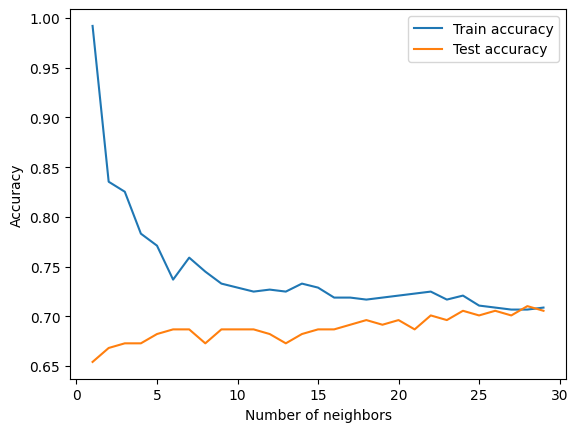

In [112]:
train_errors = []
test_errors = []
neighbors = range(1, 30)

for n in neighbors:
    model = KNeighborsClassifier(n_neighbors=n)
    model.fit(X_train, y_train)
    train_errors.append(accuracy_score(y_train, model.predict(X_train)))
    test_errors.append(accuracy_score(y_test, model.predict(X_test)))

plt.plot(neighbors, train_errors, label='Train accuracy')
plt.plot(neighbors, test_errors, label='Test accuracy')
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

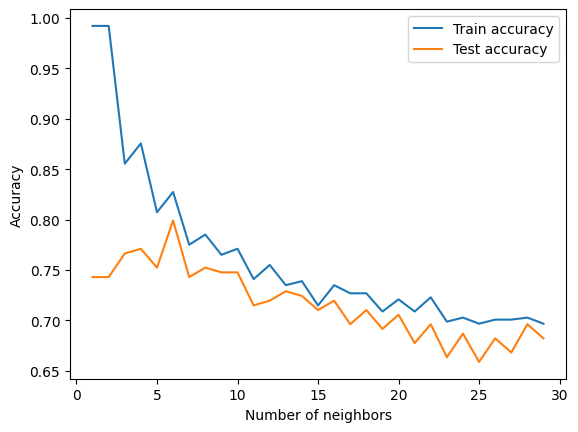

In [113]:
train_errors = []
test_errors = []
neighbors = range(1, 30)

for n in neighbors:
    model = KNN(k=n)
    model.fit(X_train, y_train)
    train_errors.append(accuracy_score(y_train, model.predict(X_train)))
    test_errors.append(accuracy_score(y_test, model.predict(X_test)))

plt.plot(neighbors, train_errors, label='Train accuracy')
plt.plot(neighbors, test_errors, label='Test accuracy')
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Поиск аномалий

Показываем степень качества алгоритма до применения вычисления априорных весов с помошью LOWWES

In [114]:
prediction = KNN(k=27, metric='minkowski', kernel='uniform', window_type='Non_fixed').fit(x_train_std, y_train).predict(x_test_std)
accuracy_score(prediction, y_test)

0.794392523364486

Text(0, 0.5, 'Accuracy')

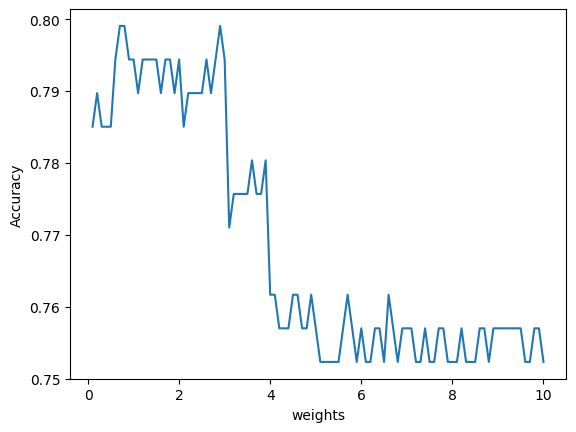

In [115]:
def lowess():
    anomalies = []
    for i in range(len(x_train_std)):
        prediction = KNN(k=27,  metric='minkowski', kernel='uniform').fit(np.delete(x_train_std, i, axis=0), np.delete(y_train, i, axis=0))
        prediction = prediction.predict(np.array([x_train_std[i]]))
        if abs(y_train[i] - prediction) == 1:
            anomalies.append(i)
    return anomalies

def get_apriory_weights(w, anomalies):
    new_weights = []
    for i in range(len(x_train_std)):
        if i in anomalies:
            new_weights.append(w)
        else:
            new_weights.append(1)
    return new_weights

def get_accuracy(w, x_test_std, y_test):
    anomalies = lowess()
    model = KNN(k=27,  metric='minkowski', kernel='uniform', apriory_weights=get_apriory_weights(w, anomalies))
    predictions = model.fit(x_train_std, y_train).predict(x_test_std)
    return accuracy_score(predictions, y_test)

xs = [x / 10 for x in range(1, 101)]
ys = [get_accuracy(w, x_test_std, y_test) for w in xs]
plt.plot(xs, ys)
plt.xlabel('weights')
plt.ylabel('Accuracy')

In [116]:
def get_lib_accuracy(X_train, y_trian, X_test, y_test):
    lib_knn = KNeighborsClassifier(n_neighbors=5, weights='distance', metric='minkowski')
    predictions = lib_knn.fit(X_train, y_trian).predict(X_test)
    return accuracy_score(y_test, predictions)

X_an, y_an = x_train_std[lowess()], y_train[lowess()]
X_train_sampled, y_train_sampled = np.concatenate((x_train_std, X_an)), np.concatenate((y_train, y_an))

print("Old accuracy", get_lib_accuracy(x_train_std, y_train, x_test_std, y_test))
print("New accuracy", get_lib_accuracy(X_train_sampled, y_train_sampled, x_test_std, y_test))

Old accuracy 0.7897196261682243
New accuracy 0.7616822429906542
